In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
#add parent folder to path 

sys.path.append('..')

import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee
import readFollicles as rf
import SRclass_follicles as srf


In [2]:
config_path = "configs_follicles"
apply_thresh = True


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = int(config.get('DEFAULT', 'prior'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')
external_hazard = config.get('DEFAULT', 'external_hazard')
if external_hazard == "None":
    external_hazard = np.inf

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(f'/{current_folder}/')[-1]
seed_file = seed_file.split(f'/{current_folder}/')[-1]
submission_folder = submission_folder.split(f'/{current_folder}/')[-1]
#remove the first / from the paths




h5_folder = f"{submission_folder}/h5_files"

In [5]:
print(data_file)

df_rounded_base2.csv


In [6]:
ds = rf.folliclesFromFile(data_file)
ds.external_hazard = external_hazard
seed = rf.readSeedFollicles(seed_file)

In [7]:
print(seed)

[0.00036562 0.00329803 0.02043081]


In [8]:
samples0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


In [9]:
len(samples0)

2776624

In [10]:
print(np.max(lnprobs0))

-499.34724557173604


In [11]:
theta = [0.00036562, 0.00329803, 0.02043081]
sim = srf.getSrFollicles(theta,npeople=npeople, t_end=t_end,nsteps=nsteps,time_step_multiplier=time_step_multiplier,parallel=True)

In [12]:
np.shape(sim.follicles)

(20000, 55)

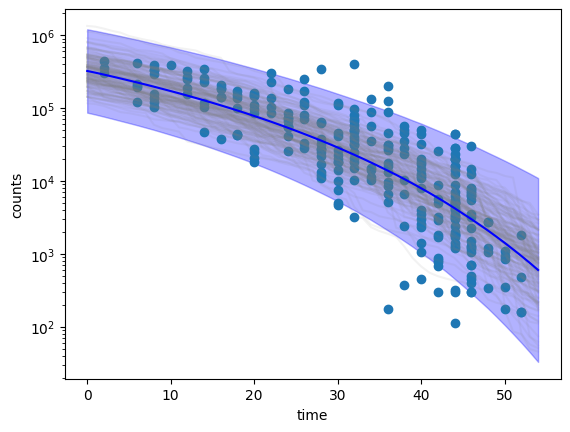

In [13]:
ax =sim.plotFollicles(ntrajectories=150, nstds=3, logstats=True, randomize_index=True)
ds.plotData(ax=ax)
ax.set_yscale('log')

In [14]:
print(srmc.karin_theta())

[0.49275, 54.75, 51.83, 17]


In [15]:
set_params = {'eta':0.49275,
              'beta':54.75,
              'epsilon':51.83,
              'xc':17,
              'external_hazard':np.inf}
kwargs = {'initial_follicles_mean':12.692312588793072,
          'initial_follicles_std': 0.441272921587803, 
          'log_initial_follicles' : True
          }
v=srf.model(theta,n=npeople,nsteps=nsteps,t_end=t_end,dataSet=ds,metric ='baysianFollicleDistance',time_step_multiplier=time_step_multiplier,parallel=True,set_params=set_params, kwargs=kwargs)

In [16]:
print(srf.baysianFollicleDistance(ds.follicles,sim))

-600.0825051936607


In [17]:
print(v)

-550.0546989461329


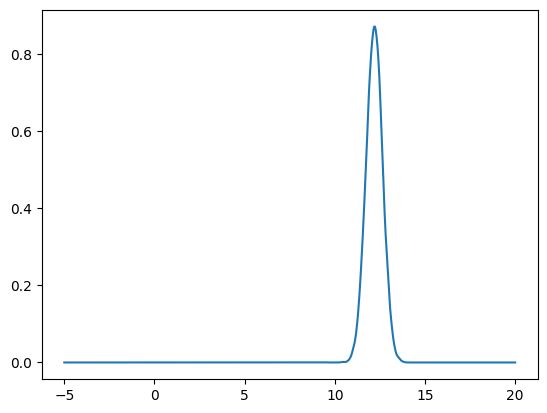

In [18]:
dists = sim.getFoliiclesDists(log_scale=True,interval=2)
x = np.linspace(-5, 20, 1000)
i=8
plt.plot(x, dists[i].pdf(x))

thresh: -744.2587417465379


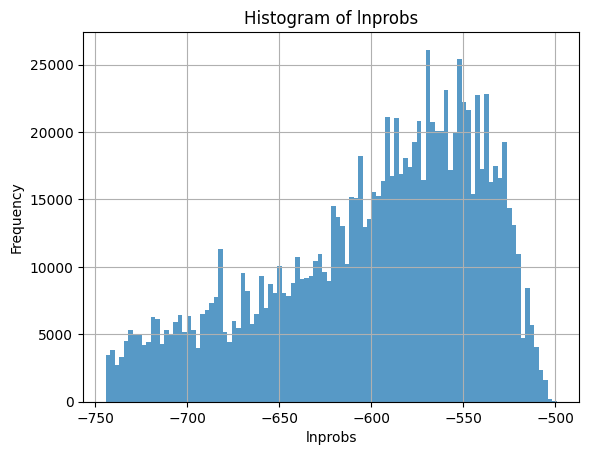

In [19]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 60)
print(f"thresh: {thresh}")
# thresh = -np.inf
plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [20]:
if apply_thresh:
    samples = samples0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

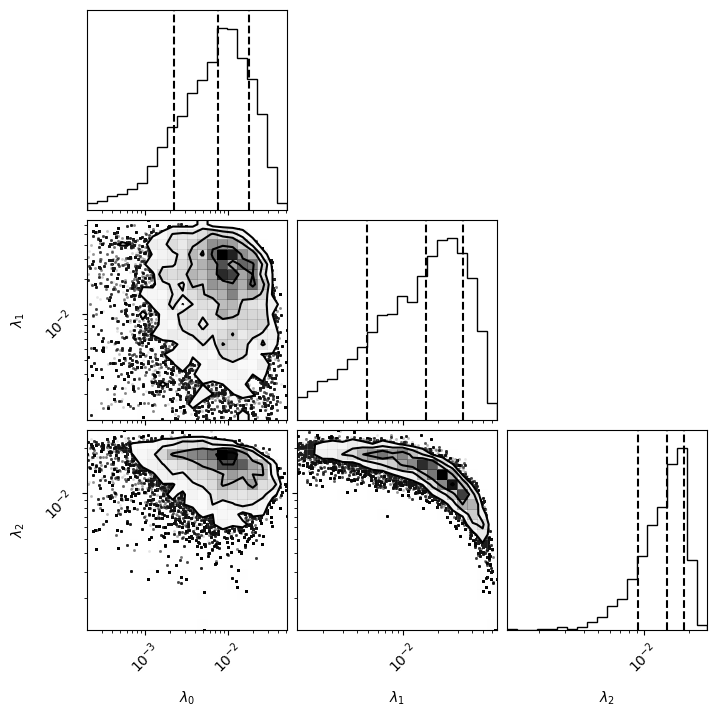

In [23]:
fig = corner.corner(samples, labels=['$\\lambda_0$','$\\lambda_1$','$\\lambda_2$'],axes_scale='log',quantiles=[0.16, 0.5, 0.84])

In [24]:
fig,ax=srmc.custom_corner(samples,lnprobs, labels=['$\\lambda_0$','$\\lambda_1$','$\\lambda_2$'])

In [22]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = lnprobs[np.argsort(lnprobs)]
theta_best = sorted_samples[-1]
params =srmc.karin_theta()

In [27]:
sim_best = srf.getSrFollicles(theta_best, params, t_end=t_end, npeople=npeople, nsteps=nsteps,time_step_multiplier=time_step_multiplier,parallel=True)

In [19]:
ds2 = rf.folliclesFromFile('data/meno_synthetic_data_golshiri2016.csv')


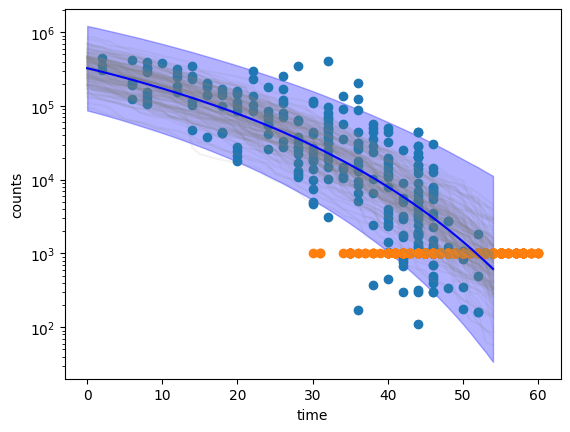

In [26]:
ax =sim_best.plotFollicles(ntrajectories=150, nstds=3, logstats=True, randomize_index=True)
ds.plotData(ax=ax)
ds2.plotData(ax=ax)
ax.set_yscale('log')

In [28]:
print(theta_best)

[0.00087558 0.00167113 0.02148401]


In [13]:
print(theta_best)

[0.00036562 0.00329803 0.02043081]


Averaging log-probabilities: 100%|██████████| 8746/8746 [00:00<00:00, 406711.93it/s]


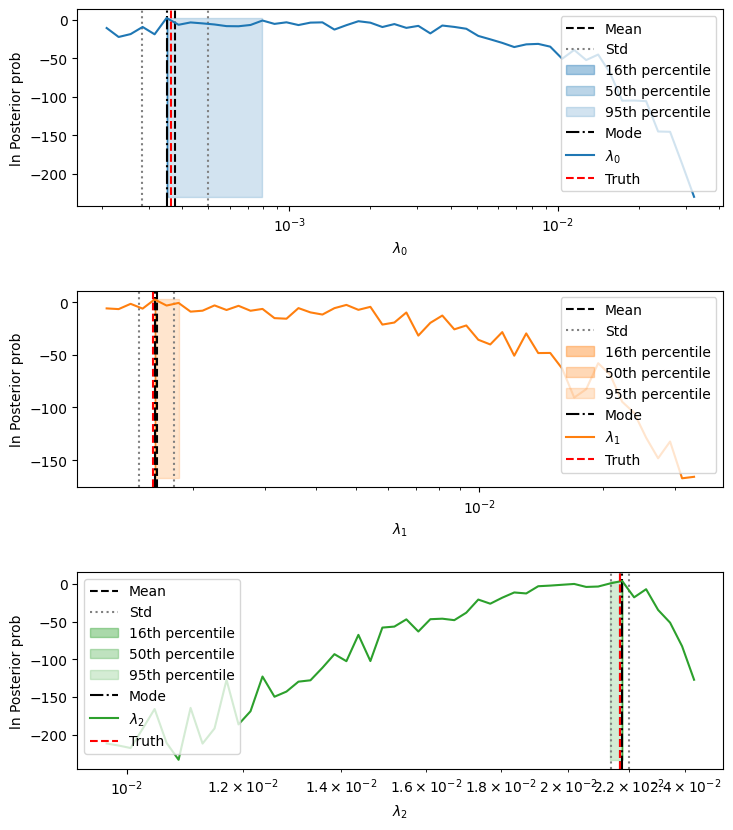

In [30]:
import samples_utils as su

post = su.Posterior(samples, lnprobs, 50, log=True)
post.plot_1d_posteriors(labels=["$\\lambda_0$","$\\lambda_1$","$\\lambda_2$"],scale='log',show_ln_prob=True, truths=theta_best,smooth_mode=False)

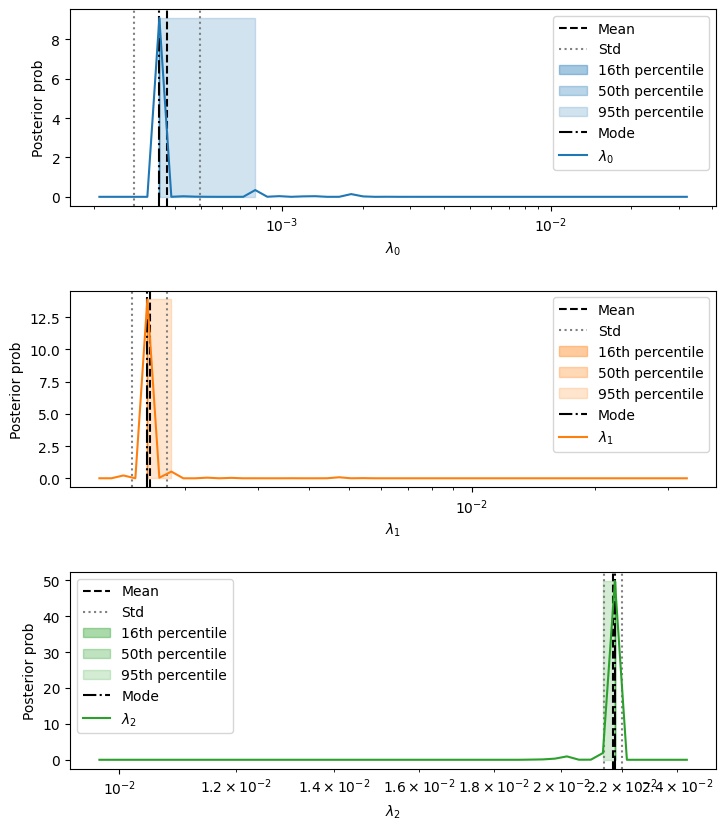

In [31]:
post.plot_1d_posteriors(labels=["$\\lambda_0$","$\\lambda_1$","$\\lambda_2$"],scale='log',show_ln_prob=False,smooth_mode=False)

/Volumes/alon/navehr/follicle_count/samples_utils.py:495: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  


array([[<Axes: xlabel='$\\lambda_0$', ylabel='ln Posterior prob'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$\\lambda_0$', ylabel='$\\lambda_1$'>,
        <Axes: xlabel='$\\lambda_1$', ylabel='ln Posterior prob'>,
        <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$\\lambda_0$', ylabel='$\\lambda_2$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\lambda_1$', ylabel='$\\lambda_2$'>,
        <Axes: xlabel='$\\lambda_2$', ylabel='ln Posterior prob'>]],
      dtype=object)

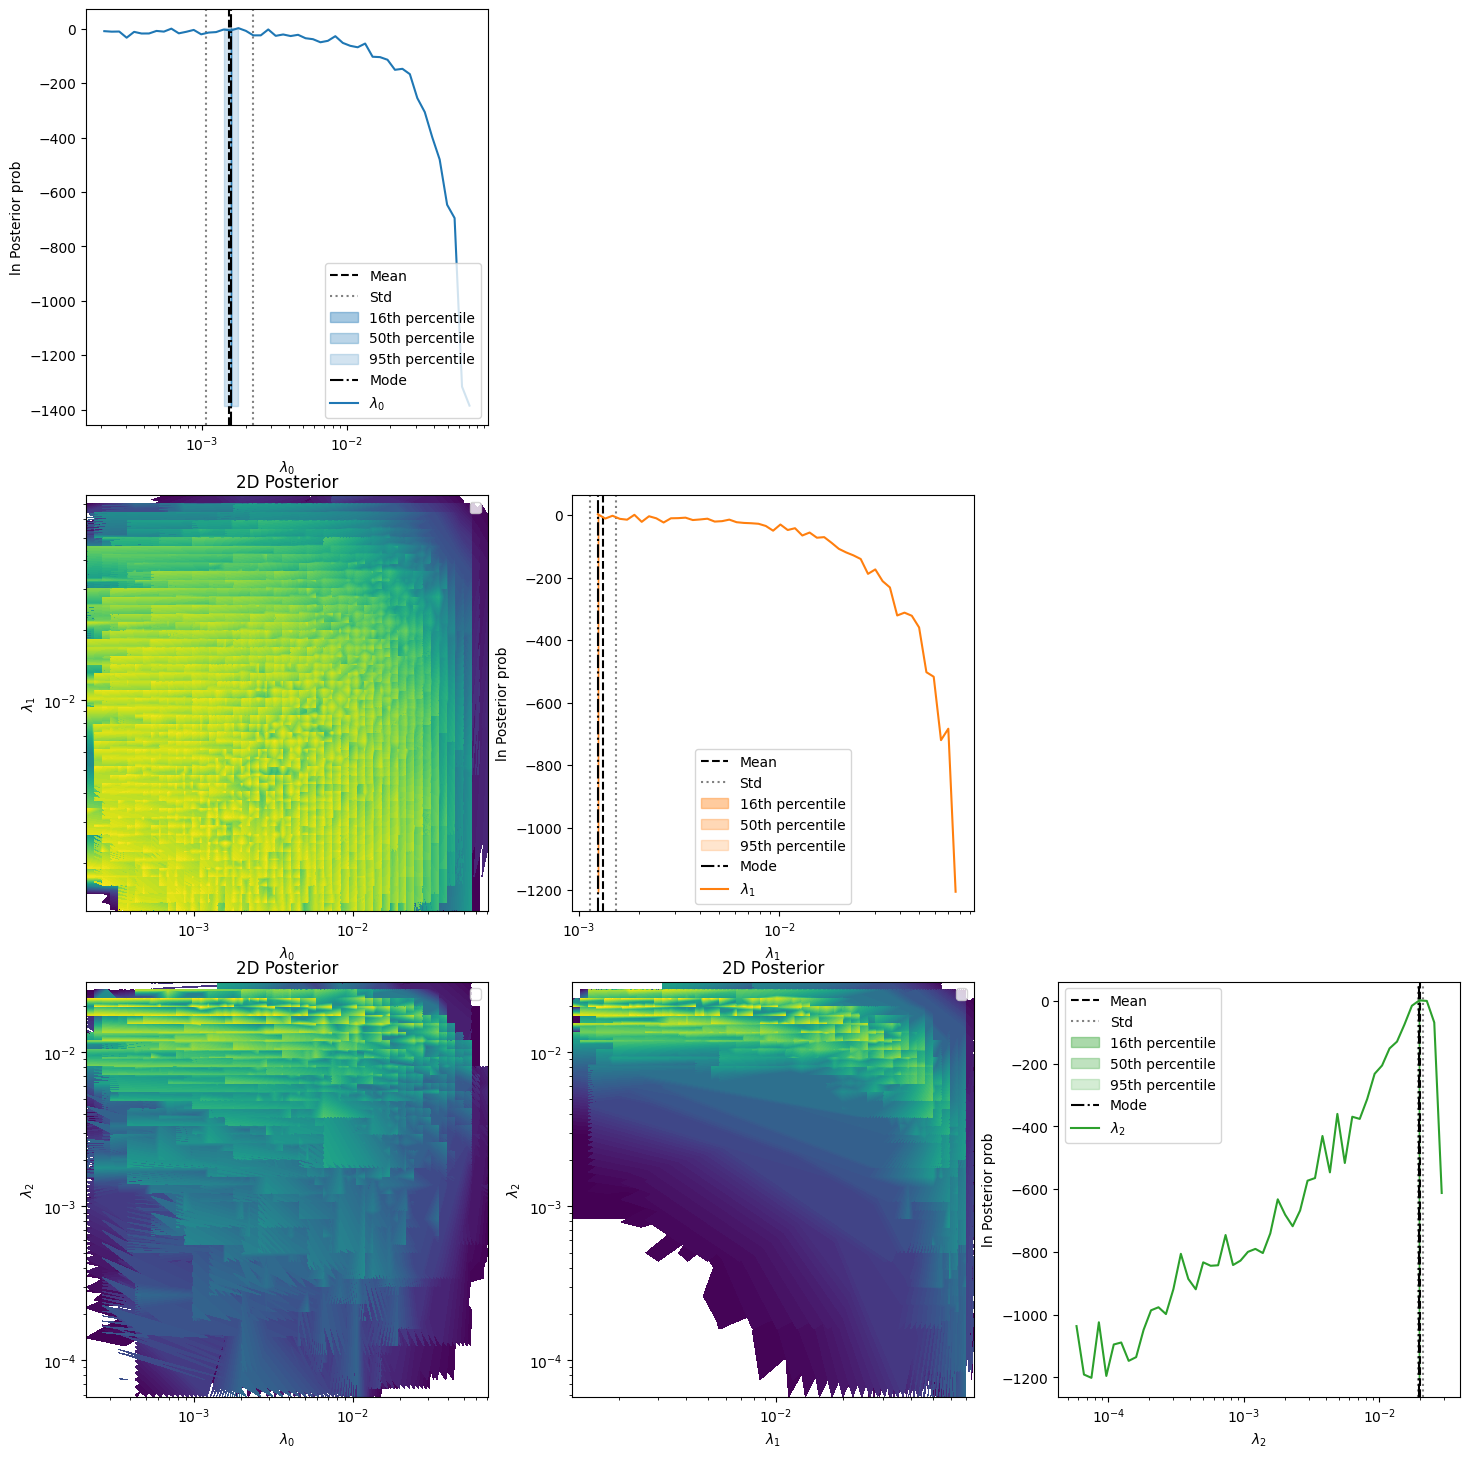

In [42]:
post.corner_plot(labels=["$\\lambda_0$","$\\lambda_1$","$\\lambda_2$"],scale='log',show_ln_prob=True, plot_type="contourf")

In [28]:
df =post.create_posterior_df(transforms=[su.identity_transform],labels=[["$\\lambda_0$","$\\lambda_1$","$\\lambda_2$"]],smooth_mode=False)

Averaging log-probabilities: 100%|██████████| 8746/8746 [00:00<00:00, 416615.18it/s]


In [29]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
$\lambda_0$,0.000374,"[0.000122, 9.21e-05]",0.000349,"[0.000349, 0.000349]","[0.000349, 0.000349]","[0.000349, 0.000795]",0.000362
$\lambda_1$,0.00164,"[0.000169, 0.000153]",0.00162,"[0.00162, 0.00162]","[0.00162, 0.00162]","[0.00162, 0.00185]",0.0016
$\lambda_2$,0.0217,"[0.000309, 0.000304]",0.0218,"[0.0218, 0.0218]","[0.0218, 0.0218]","[0.0214, 0.0218]",0.0217
